In [1]:
import json

input_image_label_pairs = {
    'validation': {
        'annotations_path': 'fashionpediaUneditedCocoDataset/validation/validation.json',
        'input_images_path': 'fashionpediaUneditedCocoDataset/validation'
    },
    'train': {
        'annotations_path': 'fashionpediaUneditedCocoDataset/train/train.json',
        'input_images_path': 'fashionpediaUneditedCocoDataset/train'
    }

}

print(json.dumps(input_image_label_pairs, indent=2))

{
  "validation": {
    "annotations_path": "/Users/chridoms/Desktop/fashionpediaUneditedCocoDataset/validation/validation.json",
    "input_images_path": "/Users/chridoms/Desktop/fashionpediaUneditedCocoDataset/validation"
  },
  "train": {
    "annotations_path": "/Users/chridoms/Desktop/fashionpediaUneditedCocoDataset/train/train.json",
    "input_images_path": "/Users/chridoms/Desktop/fashionpediaUneditedCocoDataset/train"
  }
}


In [25]:
import numpy as np
import cv2
import json
import os
from collections import defaultdict
from matplotlib import pyplot as plt
import copy

annotation_to_image_dict = defaultdict(list)
annotation_id_to_annotation = {}
image_id_to_image = {}
category_id_to_category = {}

blocked_super_categories = {
    'garment parts',
    'decorations',
    'closures'
}

blocked_category_ids = {}
file_type = 'train'
input_annotations_path = input_image_label_pairs[file_type]['annotations_path']
input_images_path = input_image_label_pairs[file_type]['input_images_path']

with open(input_annotations_path, 'r') as f:
    coco = json.load(f)
    for cat in coco['categories']:
        if (cat['supercategory'] in blocked_super_categories):
            blocked_category_ids[cat['id']] = cat
        else:
            category_id_to_category[cat['id']] = cat

with open(input_annotations_path, 'r') as f:
    coco = json.load(f)
    for annotation in coco['annotations']:
        if (annotation['category_id'] in blocked_category_ids):
            continue
        annotation_to_image_dict[annotation['image_id']].append(annotation)
        annotation_id_to_annotation[annotation['id']] = annotation
    for image in coco['images']:
        image_id_to_image[image['id']] = image

category_names = []
for category in category_id_to_category:
    category_names.append(category_id_to_category[category]['name'])

category_names.sort()

category_id_to_output_number = {}

for category in category_id_to_category:
    index = category_names.index(category_id_to_category[category]['name'], 0, len(category_names))
    category_id_to_output_number[category] = index

In [26]:
print(f'images size: {len(image_id_to_image.keys())}')
annotation_count = 0
for image_id in image_id_to_image:
    image_annotations = annotation_to_image_dict[image_id]
    annotation_count += len(image_annotations)
print(f'annotation_count: {annotation_count}')
print(f'labels size: {len(annotation_id_to_annotation.keys())}')
assert(annotation_count == len(annotation_id_to_annotation.keys()))

images size: 45623
annotation_count: 163060
labels size: 163060


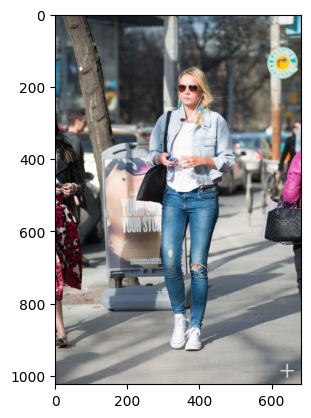

In [27]:
import random

# // image in raw dataset
random_image = random.choice(list(image_id_to_image.values()))
random_image_id = random_image['id']
random_file_name = random_image['file_name']

image = image_id_to_image[random_image_id]
image_annotations = annotation_to_image_dict[random_image_id]
image_filepath = os.path.join(input_images_path, image['file_name'])
test_image = cv2.cvtColor(cv2.imread(image_filepath), cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.show()

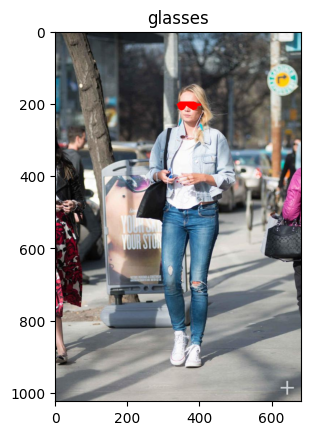

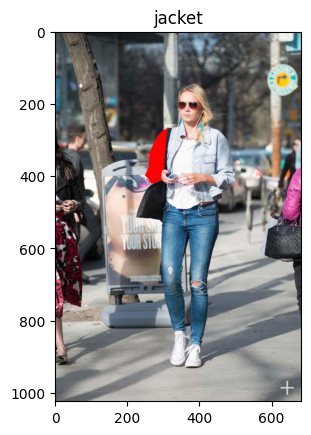

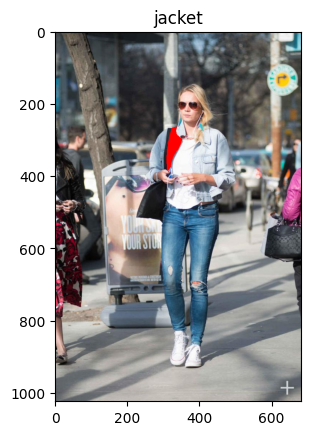

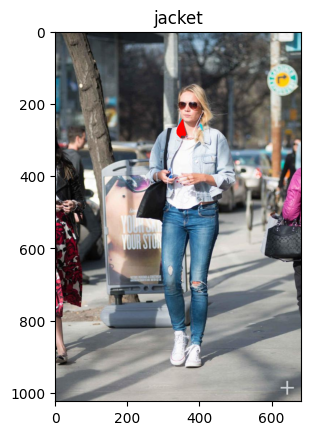

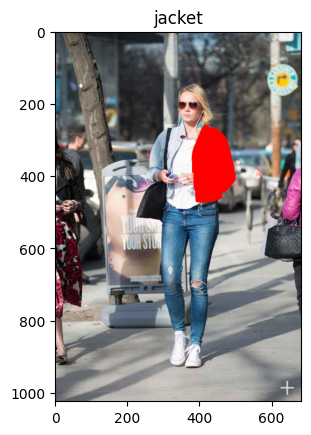

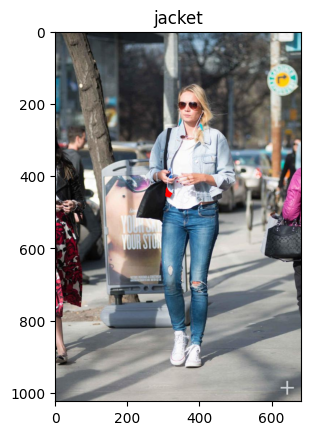

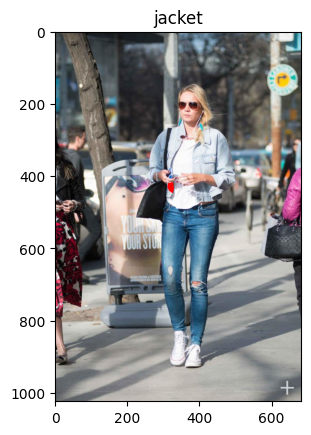

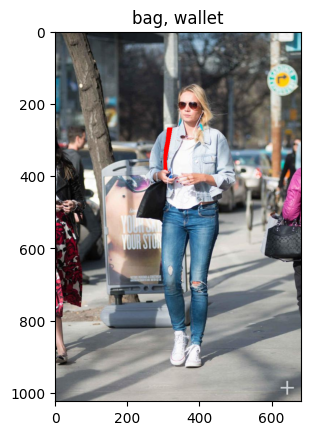

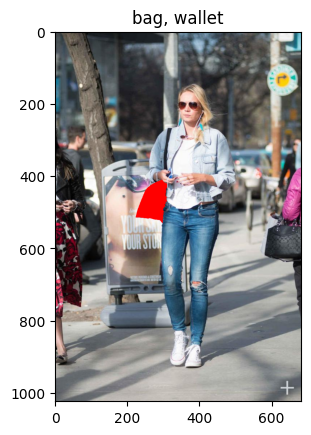

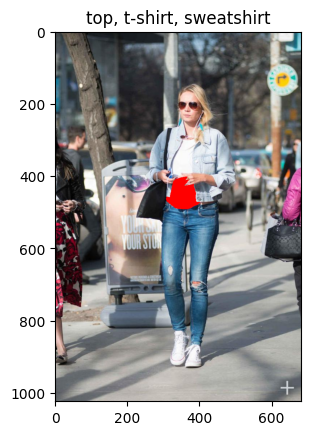

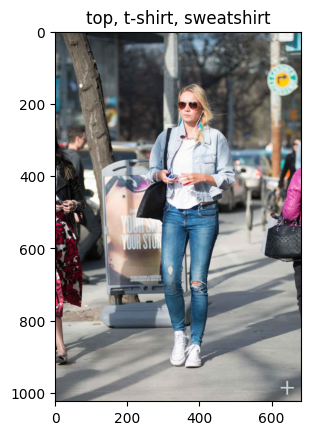

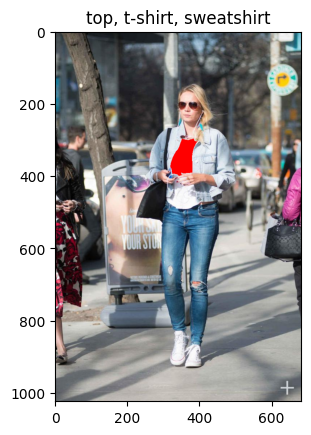

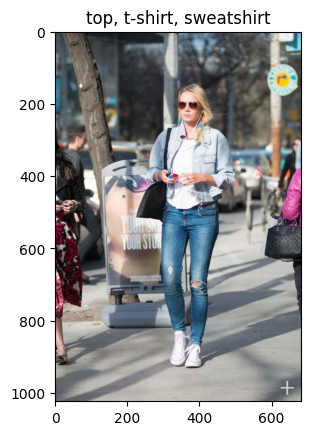

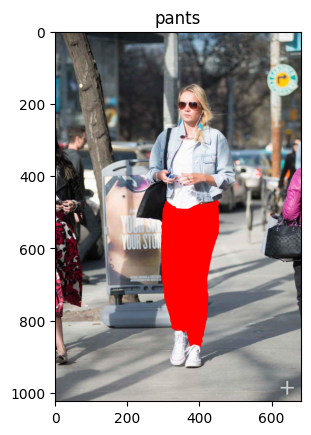

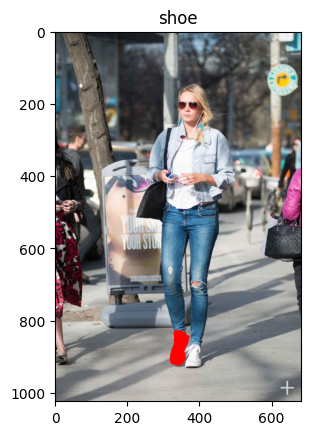

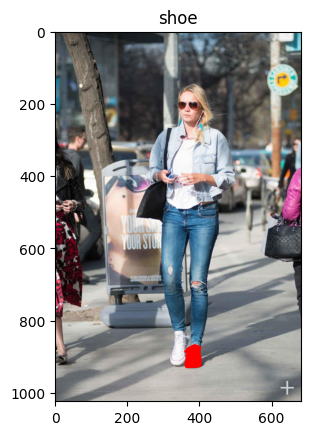

In [28]:
for annotation in image_annotations:
    category_id = annotation['category_id']
    category_name = category_id_to_category[category_id]['name']
    segmentation = annotation['segmentation']
    if type(segmentation) == list:
        for seg in segmentation:
            image_copy = copy.copy(test_image)
            xyPoints = []
            for i in range(0, len(seg), 2):
                x, y = seg[i:i + 2]
                xyPoints.append((x, y))
                mask_color = [255, 0, 0]
                mask_outline = [255, 0, 0]
                points = np.array(xyPoints, dtype=np.int32)
                image_copy = cv2.fillPoly(image_copy, [points], mask_color)
                image_copy = cv2.polylines(image_copy, [points],
                                           True, mask_outline, 1)
            plt.title(category_id_to_category[int(annotation['category_id'])]['name'])
            plt.imshow(image_copy)
            plt.show()

In [30]:
output_path = 'fashionpediaYoloFormatMultiInstance/train'
IMAGES = 'images'
LABELS = 'labels'

images_output_directory = os.path.join(output_path, IMAGES)
labels_output_directory = os.path.join(output_path, LABELS)
if not os.path.exists(images_output_directory):
    os.mkdir(images_output_directory)
if not os.path.exists(labels_output_directory):
    os.mkdir(labels_output_directory)
count = 0
for image_id in image_id_to_image:
    image_json = image_id_to_image[image_id]
    full_image_file_path = os.path.join(input_images_path, image_json['file_name'])
    image = cv2.cvtColor(cv2.imread(full_image_file_path), cv2.COLOR_BGR2RGB)
    height, width, channel = image.shape
    image_file_name = image_json['file_name']
    label_file_name = os.path.splitext(image_file_name)[0] + '.txt'
    label_file_path = os.path.join(labels_output_directory, label_file_name)
    image_annotations = annotation_to_image_dict[image_id]
    with open(label_file_path, 'a') as f:
        # delete file if it already exists
        f.truncate(0)
        for annotation in image_annotations:
            category_id = annotation['category_id']
            segmentation = annotation['segmentation']
            image_copy = copy.copy(image)
            if type(segmentation) == list:
                output_category_number = category_id_to_output_number[category_id]
                for seg in segmentation:
                    f.write(str(output_category_number) + ' ')
                    for i in range(0, len(seg), 2):
                        x, y = seg[i:i + 2]
                        x = x / width
                        y = y / height
                        f.write(str(x) + ' ')
                        f.write(str(y) + ' ')
                    f.write('\n')
        cv2.imwrite(os.path.join(images_output_directory, image_file_name), cv2.cvtColor(image_copy, cv2.COLOR_RGB2BGR))
print('done....')

done....


In [4]:
# I use the output here for the yolo yaml file
category_names.sort()
for cat_name in category_names:
    print(f'- {cat_name}')

Annotations /Users/chridoms/Desktop/fullFashionpediaUpdatedCocoStyle/train/train.json: 100%|██████████| 45623/45623 [00:14<00:00, 3143.62it/s]


In [ ]:
# import shutil
# from general_json2yolo import min_index
# from general_json2yolo import convert_coco_json
# from pathlib import Path
# import contextlib
# import json
# import tqdm
# import cv2
# import pandas as pd
# from PIL import Image
# from collections import defaultdict
# import os
# from utils import *
# from utils import *
#
# convert_coco_json('copyOfValidation/', True)
